In [88]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import ssl

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

seed = 1234
np.random.seed(seed)

ssl._create_default_https_context = ssl._create_unverified_context

In [62]:
batch_size = 256

gen = torch.Generator()
gen.manual_seed(seed)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0, 1)])

trainset, valset = random_split(
    torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform),
    [0.8, 0.2],
    generator=gen
)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
    batch_size=batch_size, shuffle=True, num_workers=2, generator=gen)
valloader = torch.utils.data.DataLoader(valset,
    batch_size=batch_size, shuffle=True, num_workers=2, generator=gen)
testloader = torch.utils.data.DataLoader(testset,
    batch_size=batch_size, shuffle=True, num_workers=2, generator=gen)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(len(trainset), len(valset), len(testset))

Files already downloaded and verified
40000 10000 10000


In [75]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity
        self.relu1 = nn.ReLU()
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function
        x = x.view(-1, input_dim)
        out = self.fc1(x)
        # Non-linearity
        out = self.relu1(out)
        # Linear function (readout)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out

input_dim = 32*32*3
hidden_dim = 100
output_dim = 10
learning_rate = 0.05
    
model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
print(model)

torch.manual_seed(seed)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)


In [106]:
input_dim = 32*32*3
hidden_dim = 100
output_dim = 10
learning_rate = 0.05
weight_decay = 5e-5

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
print(model)

torch.manual_seed(seed)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
iter = 0
losses = []
for epoch in range(40):
    for i, (images, labels) in enumerate(trainloader):
        # Load images with gradient accumulation capabilities

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        losses.append(loss.item())

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in trainloader:
                # Load images with gradient accumulation capabilities

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)

                # Total number of labels
                total += labels.size(0)

                # Total correct predictions
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)
Iteration: 500. Loss: 1.8943012952804565. Accuracy: 30.239999771118164
Iteration: 1000. Loss: 1.7981674671173096. Accuracy: 36.724998474121094
Iteration: 1500. Loss: 1.6445943117141724. Accuracy: 40.81999969482422
Iteration: 2000. Loss: 1.7043440341949463. Accuracy: 40.279998779296875
Iteration: 2500. Loss: 1.6057250499725342. Accuracy: 41.7599983215332
Iteration: 3000. Loss: 1.587646245956421. Accuracy: 46.037498474121094
Iteration: 3500. Loss: 1.4290412664413452. Accuracy: 48.529998779296875
Iteration: 4000. Loss: 1.6168735027313232. Accuracy: 47.97999954223633
Iteration: 4500. Loss: 1.3341379165649414. Accuracy: 49.599998474121094
Iteration: 5000. Loss: 1.44

Text(0.5, 1.0, 'Loss over Epochs')

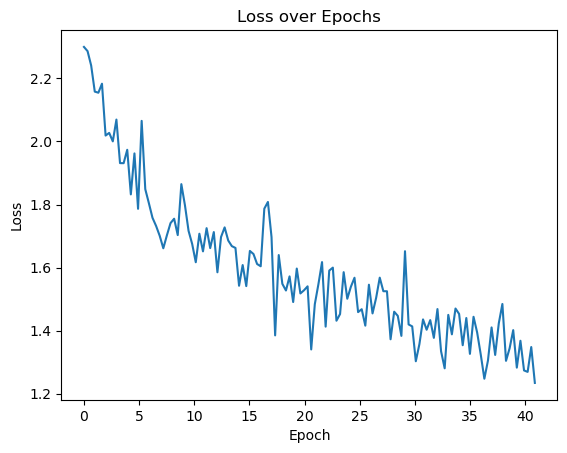

In [116]:
l = list(range(1, 6281))
losses_less = []
l_less = []
for i in range(0, len(l), 50):
    losses_less.append(losses[i])
    l[i] /= 153
    l_less.append(l[i])
plt.plot(l_less, losses_less)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")


In [79]:
correct = 0
total = 0
# Iterate through test dataset
for images, labels in valloader:
    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)

    # Total number of labels
    total += labels.size(0)

    # Total correct predictions
    correct += (predicted == labels).sum()

accuracy = 100 * correct / total

# Print Loss
print('Loss: {}. Accuracy: {}'.format(loss.item(), accuracy))

Loss: 1.3703254461288452. Accuracy: 47.5099983215332


Loss: 1.3703254461288452. Accuracy: 48.630001068115234


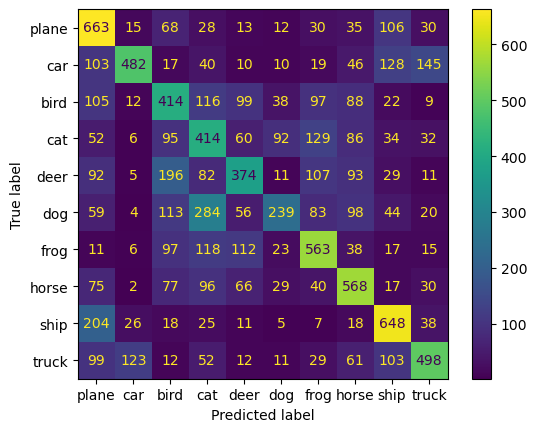

In [98]:
correct = 0
total = 0
y_pred = []
y_true = []
# Iterate through test dataset
for images, labels in testloader:
    # Forward pass only to get logits/output
    outputs = model(images)

    # Get predictions from the maximum value
    _, predicted = torch.max(outputs.data, 1)

    # Total number of labels
    total += labels.size(0)
    
    y_pred.extend(predicted)
    y_true.extend(labels)

    # Total correct predictions
    correct += (predicted == labels).sum()

accuracy = 100 * correct / total

# Print Loss
print('Loss: {}. Accuracy: {}'.format(loss.item(), accuracy))

cf_matrix = confusion_matrix(y_true, y_pred)
sklearn_disp = ConfusionMatrixDisplay(confusion_matrix = cf_matrix, display_labels=('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'))
sklearn_disp.plot();

NameError: name 'y_true' is not defined